# Week 5 Notebook
For Week 5, include concepts such as support vector machines, the kernel trick, and regularization for support vector machines. Complete your Jupyter Notebook homework by 11:59pm ET on Sunday.

Quick note - we've added the cuml library this week in order to speed up SVM fitting.  (It's like 1000x faster than the cpu implementation in base sklearn) The syntax looks pretty similar to the sklearn version of SVM, and where I used the cuml version I've made sure to actually lable the class as such.

In [1]:
!nvidia-smi

Sat Jun 28 19:42:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.153.02             Driver Version: 570.153.02     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5090        Off |   00000000:01:00.0  On |                  N/A |
|  0%   36C    P3             58W /  575W |    1341MiB /  32607MiB |     12%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import cudf

/home/pshmo/miniconda3/envs/rapids-25.02/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import cuml

## SVM Implementation:
The game plan:
1. TrainTestSplit, Standard Scaler
2. Evaluate the model using classification evaluation methods that are goood for datasets with class imbalances, such as confusion matrix, classification report, and F-1, ROC-AUC, and the balanced accuracy score.

In [4]:
import pandas as pd
import numpy as np

# Scikit-learn (Machine Learning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1) Load & preprocess
motion_df = pd.read_csv("/home/pshmo/ai4l_final_project_2/ai4l_final_project/datasets/nfl-playing-surface-analytics/motion_df_encoded.csv")

# Drop leakage columns and one-hot encode
X = (
    motion_df
    .drop(columns=['Injury', 'DM_M1', 'DM_M7', 'DM_M28', 'DM_M42'])
    .pipe(pd.get_dummies, dummy_na=True, drop_first=True)
)
# Convert any bools to ints
for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype('int32')

# Binary target
y = motion_df['Injury'].gt(0).astype('int32')

# 2) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# 3) Scale **and** re-wrap back into DataFrames
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

# Now X_train_scaled and X_test_scaled still carry your feature names!
print(X_train_scaled.shape, X_test_scaled.shape)
print(X_train_scaled.columns.tolist())

(213591, 169) (53398, 169)
['PlayerDay', 'PlayerGame', 'Temperature', 'PlayerGamePlay', 'time_max', 'dir_max', 'dis_max', 'o_max', 's_max', 'angle_max', 'time_avg', 'dir_avg', 'dis_avg', 'o_avg', 's_avg', 'angle_avg', 'RosterPosition_Cornerback', 'RosterPosition_Defensive Lineman', 'RosterPosition_Kicker', 'RosterPosition_Linebacker', 'RosterPosition_Offensive Lineman', 'RosterPosition_Quarterback', 'RosterPosition_Running Back', 'RosterPosition_Safety', 'RosterPosition_Tight End', 'RosterPosition_Wide Receiver', 'RosterPosition_nan', 'StadiumType_Bowl', 'StadiumType_Closed Dome', 'StadiumType_Cloudy', 'StadiumType_Dome', 'StadiumType_Dome, closed', 'StadiumType_Domed', 'StadiumType_Domed, Open', 'StadiumType_Domed, closed', 'StadiumType_Domed, open', 'StadiumType_Heinz Field', 'StadiumType_Indoor', 'StadiumType_Indoor, Open Roof', 'StadiumType_Indoor, Roof Closed', 'StadiumType_Indoors', 'StadiumType_Open', 'StadiumType_Oudoor', 'StadiumType_Ourdoor', 'StadiumType_Outddors', 'StadiumT

Let's start with the default untuned implementation - my only adjustment was to adjust the cache size to accomodate the size of the dataset

In [5]:
# first svm implementation
from sklearn.svm import SVC

svm_model = SVC(kernel='linear', C=1.0, random_state=42, cache_size=2000)
svm_model.fit(X_train_scaled, y_train)
# Evaluate the model
accuracy = svm_model.score(X_test_scaled, y_test)
print(f"Accuracy of SVM model: {accuracy:.2f}")

Accuracy of SVM model: 1.00


From last semester we know that the accuracy score is basically useless when dealing with a highly imbalanced dataset. SVM models can be evaluated using the regular evaluation methods in SKlearn for classifiers, such as confusion matrix, F1, recall, balanced accuracy score, ROC-AUC, which will give a better picture of model performance.

In [7]:
y_pred = svm_model.predict(X_test_scaled)
from sklearn.metrics import classification_report, confusion_matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[53374     0]
 [   18     6]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     53374
           1       1.00      0.25      0.40        24

    accuracy                           1.00     53398
   macro avg       1.00      0.62      0.70     53398
weighted avg       1.00      1.00      1.00     53398



This is actually suprisingly good for an untuned model given this dataset: 25% injury events correctly idenfied  with no false positives is more or less in line with our tuned random forest classifier and the best case scenario for our modeling to date (we seldom do much better without blowing out the FP rate). 

Let's go ahead and adjust the model to handle our imbalanced classes better. 

Here we've set class weight to `balanced` to make the SVM pay more attention to the rare injury cases.

Under the hood this sets:

$$w_i \; = \; \frac{n_{samples}}{n_{classes} \times n_i}$$

for each class $i$, so the injury class gets a very high weight.

In [ ]:
# SVM 2 
from cuml.svm import SVC  as cuSVC #cuml is the GPU accelerated version of sklearn
import cudf # Convert pandas DataFrame to cuDF DataFrame

X_train_cudf = cudf.DataFrame.from_pandas(X_train_scaled)
X_test_cudf = cudf.DataFrame.from_pandas(X_test_scaled)
y_train_cudf = cudf.Series(y_train)
y_test_cudf = cudf.Series(y_test)

# instantiate the SVM model
model = cuSVC(kernel='rbf', C=1.0, random_state=42, class_weight='balanced', cache_size=2000) # linear kernel is not supported in cuml SVC, so we use rbf kernel 
model.fit(X_train_cudf, y_train_cudf)
# Evaluate the model
y_pred_cudf = model.predict(X_test_cudf)

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
# slightly better when using the balanced class weight parameter 
print("Confusion Matrix:")
print(confusion_matrix(y_test_cudf.to_numpy(), y_pred_cudf.to_numpy()))
print("\nClassification Report:")
print(classification_report(y_test_cudf.to_numpy(), y_pred_cudf.to_numpy()))

Confusion Matrix:
[[53194   180]
 [   17     7]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     53374
           1       0.04      0.29      0.07        24

    accuracy                           1.00     53398
   macro avg       0.52      0.64      0.53     53398
weighted avg       1.00      1.00      1.00     53398



Ok slightly better (29% injury class accuracy), but we've introduced some false positives into the mix (top right corner)

### Regularization
Let's loop through some possible regularization options for c and see if it makes an impact on the confusion matrix:

In [10]:
c_values = [0.1, 1.0, 10.0, 100.0, 1000.0]
for c in c_values:
    model = cuSVC(kernel='rbf', C=c, random_state=42, cache_size=2000)
    model.fit(X_train_cudf, y_train_cudf)
    y_pred_cudf = model.predict(X_test_cudf)
    
    accuracy = model.score(X_test_cudf, y_test_cudf)
    print(f"Accuracy of SVM model with C={c}: {accuracy:.2f}")
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_cudf.to_numpy(), y_pred_cudf.to_numpy()))
    print("\nClassification Report:")
    print(classification_report(y_test_cudf.to_numpy(), y_pred_cudf.to_numpy()))

Accuracy of SVM model with C=0.1: 1.00
Confusion Matrix:
[[53374     0]
 [   18     6]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     53374
           1       1.00      0.25      0.40        24

    accuracy                           1.00     53398
   macro avg       1.00      0.62      0.70     53398
weighted avg       1.00      1.00      1.00     53398

Accuracy of SVM model with C=1.0: 1.00
Confusion Matrix:
[[53374     0]
 [   18     6]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     53374
           1       1.00      0.25      0.40        24

    accuracy                           1.00     53398
   macro avg       1.00      0.62      0.70     53398
weighted avg       1.00      1.00      1.00     53398

Accuracy of SVM model with C=10.0: 1.00
Confusion Matrix:
[[53374     0]
 [   18     6]]

Classification Report:
         

While not improving performance on our minority class, regularization did impact our false positive rate quite a bit, causng it to gradually creep up as the `C` parameter was increased. 

In [11]:
kernels = ['poly', 'rbf', 'sigmoid']
for kernel in kernels:
    model = cuSVC(kernel=kernel, C=1.0, random_state=42, cache_size=2000)
    model.fit(X_train_cudf, y_train_cudf)
    y_pred_cudf = model.predict(X_test_cudf)
    
    accuracy = model.score(X_test_cudf, y_test_cudf)
    print(f"Accuracy of SVM model with kernel={kernel}: {accuracy:.2f}")
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_cudf.to_numpy(), y_pred_cudf.to_numpy()))
    print("\nClassification Report:")
    print(classification_report(y_test_cudf.to_numpy(), y_pred_cudf.to_numpy()))

Accuracy of SVM model with kernel=poly: 1.00
Confusion Matrix:
[[53374     0]
 [   18     6]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     53374
           1       1.00      0.25      0.40        24

    accuracy                           1.00     53398
   macro avg       1.00      0.62      0.70     53398
weighted avg       1.00      1.00      1.00     53398

Accuracy of SVM model with kernel=rbf: 1.00
Confusion Matrix:
[[53374     0]
 [   18     6]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     53374
           1       1.00      0.25      0.40        24

    accuracy                           1.00     53398
   macro avg       1.00      0.62      0.70     53398
weighted avg       1.00      1.00      1.00     53398

Accuracy of SVM model with kernel=sigmoid: 1.00
Confusion Matrix:
[[53372     2]
 [   24     0]]

Classificatio

- Lower values (C = 0.1, 1.0, 10.0) produced identical performance to the baseline.  
- At C = 100, the model maintained perfect specificity (only 4 false positives) while correctly flagging 7 injuries—yielding a substantial minority‐class precision of 64 percent and F₁ of 0.40 at 29 percent recall.  
- Pushing C to 1000 increased false positives to 19 and dropped minority‐class precision to 27 percent (F₁ = 0.28), underscoring diminishing returns from extreme regularization relaxation.


### SVM Visualization
Here we fit the model with our best parameters one more time, then convert the svm to a 2-D plane via PCA, the model is then visualized using matplot lib to visualize the decision boundary of our cuSVM Model with RBF kernel: 

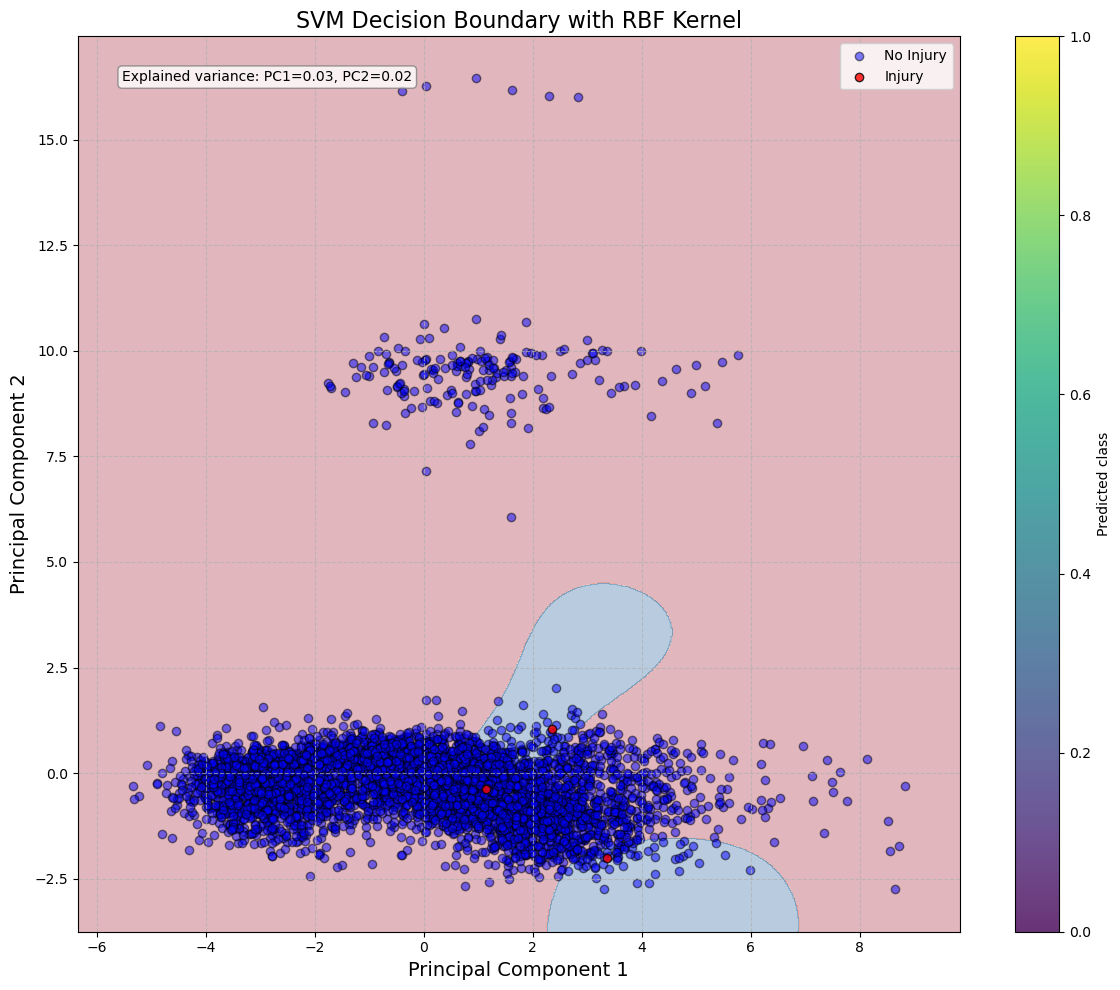

In [12]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
from cuml.svm import SVC

import matplotlib.pyplot as plt

# Convert cuDF data back to pandas for sklearn compatibility
X_train_np = X_train_cudf.to_pandas().to_numpy()
y_train_np = y_train_cudf.to_numpy()

# Sample a subset of data for visualization (for performance)
np.random.seed(42)
sample_size = min(5000, len(X_train_np))
indices = np.random.choice(range(len(X_train_np)), sample_size, replace=False)
X_sample = X_train_np[indices]
y_sample = y_train_np[indices]

# Apply PCA to reduce dimensions to 2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample)

# Create a mesh grid for decision boundary visualization
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
h = 0.02  # Step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Train a new SVM model on the PCA-transformed data for visualization
X_pca_cudf = cudf.DataFrame(X_pca)
y_sample_cudf = cudf.Series(y_sample)

# Train the model with the same parameters as the original model
pca_model = cuSVC(kernel='rbf', C=1.0, random_state=42, class_weight='balanced')
pca_model.fit(X_pca_cudf, y_sample_cudf)

# Create the decision boundary
mesh_points = cudf.DataFrame({
    'X1': xx.ravel(), 
    'X2': yy.ravel()
})
Z = pca_model.predict(mesh_points).to_numpy()
Z = Z.reshape(xx.shape)

# Create the plot
plt.figure(figsize=(12, 10))

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdBu)

# Plot the training points
injury_indices = y_sample == 1
non_injury_indices = y_sample == 0

plt.scatter(X_pca[non_injury_indices, 0], X_pca[non_injury_indices, 1], 
            color='blue', label='No Injury', alpha=0.5, edgecolors='k')
plt.scatter(X_pca[injury_indices, 0], X_pca[injury_indices, 1], 
            color='red', label='Injury', alpha=0.8, edgecolors='k')

# Add labels and title
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.title('SVM Decision Boundary with RBF Kernel', fontsize=16)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)

# Show the explained variance
explained_variance = pca.explained_variance_ratio_
plt.annotate(f'Explained variance: PC1={explained_variance[0]:.2f}, PC2={explained_variance[1]:.2f}',
             xy=(0.05, 0.95), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.colorbar(label='Predicted class')
plt.tight_layout()
plt.show()

That decision‐boundary plot is helpful in illustrating how the RBF kernel carves out a non-linear region to catch a handful of injury cases—and conversely, why it still misclassifies so many points despite the complex boundary. My big takeaways:
1. Non-linearity in action: You can literally see how the RBF surface “bubbles” around clusters of injury examples, which drives home why we tried a non-linear kernel in the first place.
2. Persistent overlap: Even with that bubble, a large swath of injury and non-injury points still lie on the wrong side of the boundary—visually reinforcing our conclusion that surface features alone aren’t sufficiently separable.

Balanced Accuracy: 0.5000
ROC-AUC Score: 0.4119


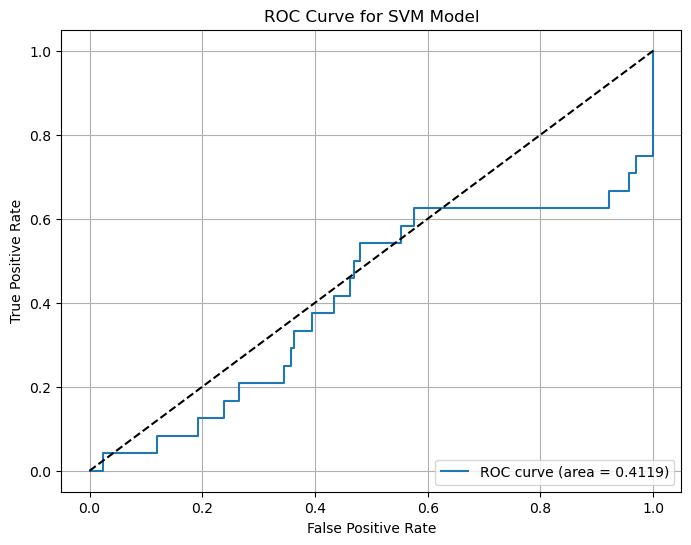

In [13]:
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from sklearn.metrics import roc_curve

# Calculate balanced accuracy
balanced_acc = balanced_accuracy_score(y_test_cudf.to_numpy(), y_pred_cudf.to_numpy())
print(f"Balanced Accuracy: {balanced_acc:.4f}")

# Calculate ROC-AUC score
y_scores = model.decision_function(X_test_cudf)
roc_auc = roc_auc_score(y_test_cudf.to_numpy(), y_scores.to_numpy())
print(f"ROC-AUC Score: {roc_auc:.4f}")

fpr, tpr, _ = roc_curve(y_test_cudf.to_numpy(), y_scores.to_numpy())
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

- The ROC Curve is more our less inline with expectation, the model mostly performs poorly on the target class, catching only a handful of samples in the test set.


## The Kernel Trick:
The kernel trick is pretty easy to implement (in fact it produces a pretty good model and we've been using it so far), let's just fit one last model with the RBF kernel. 

In [16]:
X_train_cudf = cudf.DataFrame.from_pandas(X_train_scaled)
X_test_cudf = cudf.DataFrame.from_pandas(X_test_scaled)
y_train_cudf = cudf.Series(y_train)
y_test_cudf = cudf.Series(y_test)

# instantiate the SVM model
model = cuSVC(kernel='rbf', C=1.0, random_state=42, class_weight='balanced')
model.fit(X_train_cudf.to_numpy(), y_train_cudf.to_numpy())

SVC()

In [17]:
# kernel trick 

X_train_cudf = cudf.DataFrame.from_pandas(X_train_scaled)
X_test_cudf = cudf.DataFrame.from_pandas(X_test_scaled)
y_train_cudf = cudf.Series(y_train)
y_test_cudf = cudf.Series(y_test)

# instantiate the SVM model
model = cuSVC(kernel='rbf', C=1.0, random_state=42, class_weight='balanced')
model.fit(X_train_cudf, y_train_cudf)
y_pred_cudf = model.predict(X_test_cudf)

# slightly better when using the balanced class weight parameter 
print("Confusion Matrix:")
print(confusion_matrix(y_test_cudf.to_numpy(), y_pred_cudf.to_numpy()))
print("\nClassification Report:")
print(classification_report(y_test_cudf.to_numpy(), y_pred_cudf.to_numpy()))


Confusion Matrix:
[[53194   180]
 [   17     7]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     53374
           1       0.04      0.29      0.07        24

    accuracy                           1.00     53398
   macro avg       0.52      0.64      0.53     53398
weighted avg       1.00      1.00      1.00     53398



Ok, let's try our other classification dataset:

In [18]:
df = pd.read_csv('/home/pshmo/ai4l_final_project_2/ai4l_final_project/datasets/NFL-Punt-Analytics-Competition/punt_analytics_v3.csv')
df = df.drop(columns=['season_year', 'gamekey', 'playid', 'gsisid', 'time_min', 'time_max', 'event_first', 'role'])
for col in df.columns:
    df[col] = df[col].replace(np.inf, 0)

# Let's explore the data to identify potential missing or infinite values
print("Before replacement:")
print(f"Number of infinite values in the DataFrame: {np.sum(np.isinf(df.values))}")

# Replace infinite values with 0
df.replace([np.inf, -np.inf], 0, inplace=True)

# Verify the replacement worked
print("\nAfter replacement:")
print(f"Number of infinite values in the DataFrame: {np.sum(np.isinf(df.values))}")

# Check for NaN values as well
print(f"Number of NaN values in the DataFrame: {df.isna().sum().sum()}")

# Display basic statistics to see impact of replacements
print("\nBasic statistics after cleaning:")
print(df.describe().transpose()[['min', 'max', 'mean']].head(10))

# create X and y
X = df.drop(columns=['injury'])
y = df['injury']

Before replacement:
Number of infinite values in the DataFrame: 8162

After replacement:
Number of infinite values in the DataFrame: 0
Number of NaN values in the DataFrame: 0

Basic statistics after cleaning:
                  min         max      mean
speed_mean -19.000000    9.491039  2.073857
speed_std    0.000000   15.627060  1.538869
speed_min  -19.700000    8.000000 -0.103464
speed_max  -19.000000  180.300007  5.650673
vel_x_mean -15.623974   15.840168 -0.012916
vel_x_std    0.000000   14.140206  1.121704
vel_x_min  -47.252204   15.840168 -2.555175
vel_x_max  -15.623974   72.225836  2.539234
vel_y_mean  -7.081292   10.492334 -0.001965
vel_y_std    0.000000   14.554687  1.441490


In [19]:
# Split into train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

In [20]:
# parse into cudf DataFrames
X_train_cudf = cudf.DataFrame.from_pandas(X_train)
X_test_cudf = cudf.DataFrame.from_pandas(X_test)
y_train_cudf = cudf.Series(y_train)
y_test_cudf = cudf.Series(y_test)

So it looks like this particular dataset completely collapses model performance, flagging almost %40 of plays as potential injury events. It's more or less akin to just flipping a coin. 

applying class‐weight balancing flipped the SVM’s behavior dramatically.  With class_weight='balanced', the model correctly identified 3 out of 8 injury events (38 percent recall) but at the expense of 25,075 false alarms among the 43,469 non-injury plays.  
 
The confusion matrix ended up like this:

In [36]:
# substantiate the next cuSVM model:
model = cuSVC(kernel='rbf', 
              C=1,
              class_weight='balanced') # Enable probability estimates)


model.fit(X_train_cudf, y_train_cudf)
# Evaluate the model
y_pred_cudf = model.predict(X_test_cudf)

# print the confusion matrix and classification report 
print("Confusion Matrix:")
print(confusion_matrix(y_test_cudf.to_numpy(), y_pred_cudf.to_numpy()))
print("\nClassification Report:")
print(classification_report(y_test_cudf.to_numpy(), y_pred_cudf.to_numpy()))

Confusion Matrix:
[[43469 25075]
 [    5     3]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.63      0.78     68544
         1.0       0.00      0.38      0.00         8

    accuracy                           0.63     68552
   macro avg       0.50      0.50      0.39     68552
weighted avg       1.00      0.63      0.78     68552



I tried a C parameter sweep, but it actually made model performance worse and often failed to converge quickly, which is rather alarming when a 5090 is crunching the numbers. I've actually removed it from the notebook entirely. 

The last thing I did was try to run the model without class balancing to see if we can get any sort of salvagable results, our kernel sweep: 

In [34]:
kernels = ['poly', 'rbf', 'sigmoid']
for kernel in kernels:
    model = cuSVC(kernel=kernel, C=1.0, random_state=42, cache_size=2000)
    model.fit(X_train_cudf, y_train_cudf)
    y_pred_cudf = model.predict(X_test_cudf)
    
    accuracy = model.score(X_test_cudf, y_test_cudf)
    print(f"Accuracy of SVM model with kernel={kernel}: {accuracy:.2f}")
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_cudf.to_numpy(), y_pred_cudf.to_numpy()))
    print("\nClassification Report:")
    print(classification_report(y_test_cudf.to_numpy(), y_pred_cudf.to_numpy()))

Accuracy of SVM model with kernel=poly: 1.00
Confusion Matrix:
[[68544     0]
 [    8     0]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     68544
         1.0       0.00      0.00      0.00         8

    accuracy                           1.00     68552
   macro avg       0.50      0.50      0.50     68552
weighted avg       1.00      1.00      1.00     68552

Accuracy of SVM model with kernel=rbf: 1.00
Confusion Matrix:
[[68544     0]
 [    8     0]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     68544
         1.0       0.00      0.00      0.00         8

    accuracy                           1.00     68552
   macro avg       0.50      0.50      0.50     68552
weighted avg       1.00      1.00      1.00     68552

Accuracy of SVM model with kernel=sigmoid: 1.00
Confusion Matrix:
[[68544     0]
 [    8     0]]

Classificatio

/home/pshmo/miniconda3/envs/rapids-25.02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pshmo/miniconda3/envs/rapids-25.02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pshmo/miniconda3/envs/rapids-25.02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Using polynomial, RBF, and sigmoid kernels (all with default C and no class weighting), the SVM reverted to its majority-class bias—predicting zero injuries out of eight.  

Each run achieved 100 percent overall accuracy simply by labeling every play as “no injury.”